In [1]:
# From eliot
import char_tokeniser
import batching
import models
import wikitext_utils

# Other imports
import importlib
import matplotlib.pyplot as plt
import torch
import tqdm

In [2]:
# Load WikiText-103
dataset = wikitext_utils.load_wikitext_train()

Found cached dataset wikitext (/home/tom/.cache/huggingface/datasets/wikitext/wikitext-103-raw-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)


In [3]:
# Train the tokeniser
vocab_size = 256
tokeniser = char_tokeniser.CharacterTokeniser(vocab_size)
tokeniser.train(dataset)

100%|██████████████████████████████| 1801350/1801350 [00:35<00:00, 50839.21it/s]


In [4]:
# Set up data source with some ambitious parameters
seq_len = 128
batch_size = 1024

text_iterator = wikitext_utils.make_shuffled_text_iterator(dataset)
process_fn = batching.make_processor(tokeniser, seq_len, discard_last=True)
datasources = [batching.DataSource(text_iterator, process_fn) for _ in range(batch_size)]

batched_data_source = batching.BatchedDataSource(datasources)

In [5]:
# Speed test
n_iters = int(1e2)

for _ in tqdm.tqdm(range(n_iters)):
    batched_data = batched_data_source.get_next()

100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 29.92it/s]


In [6]:
# Read and check we've not got autocorrelation
for i in range(5):
    batch_string = tokeniser.detokenise_to_string(batched_data['tokens'][i])
    print(f'Item {i} in batch:\n {batch_string}\n')

Item 0 in batch:
  " Super Meat Boy 's greatest strength has to be how it never takes itself too seriously — as maddening as some of the levels go

Item 1 in batch:
 eason , registering a 19 @-@ 15 record . During the 1905 season , Chesbro was involved in the first squeeze play in baseball . A

Item 2 in batch:
 efan Dennis as the mustache @-@ twirling panto villain Paul Robinson , is a genius . I just wanted to yell out ' He 's behind yo

Item 3 in batch:
  get into the wrong types of things , especially gangbanging and selling drugs . I 've seen what that was like , and I don 't gl

Item 4 in batch:
  scheduled for the weekend of July 8 and July 9 at Camp Hansen and Marine Corps Air Station Futenma had to be postponed . Tropic



In [9]:
# Model training
linear_model = models.LinearModel(vocab_size, embedding_size)

lr = 0.1
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=lr)

n_steps = 100
losses = []
for _ in tqdm.tqdm(range(n_steps)):
    # Get data
    batched_data = batched_data_source.get_next()
    tokens = torch.tensor(batched_data['tokens'])
    targets = torch.tensor(batched_data['targets'])
    
    # Compute predictions
    logits = linear_model(tokens)
    
    # Compute loss
    flat_logits = torch.flatten(logits, start_dim=0, end_dim=1)
    flat_targets = torch.flatten(targets)
    loss = loss_fn(flat_logits, flat_targets)
    losses.append(loss.detach().numpy())
    
    # Apply SGD
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|█████████████████████████████████████████| 100/100 [00:17<00:00,  5.67it/s]


Text(0, 0.5, 'Mean log-loss')

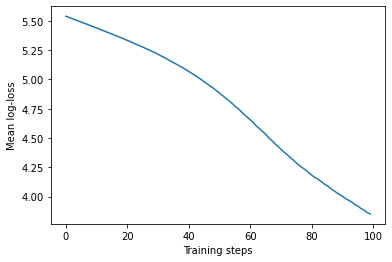

In [11]:
# 'Training' curve
fig, axes = plt.subplots(1)
axes.plot(losses)
axes.set_xlabel('Training steps')
axes.set_ylabel('Mean log-loss')